<a href="https://colab.research.google.com/github/RATFIVE/GEOMAR-DeepLearning/blob/main/app/backend/small-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

## Clone the data from GitHub

In [2]:
"""
import os
if not os.path.exists('GEOMAR-DeepLearning'):
    print(f'GEOMAR-DeepLearning does not exist')
    !git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git
    %cd GEOMAR-DeepLearning/app/backend
    !git pull
    !pip install -r requirements.txt
else:
    print(f'GEOMAR-DeepLearning exists')
    %cd GEOMAR-DeepLearning/app/backend
    !git pull
    !pip install -r requirements.txt

"""

"\nimport os\nif not os.path.exists('GEOMAR-DeepLearning'):\n    print(f'GEOMAR-DeepLearning does not exist')\n    !git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git\n    %cd GEOMAR-DeepLearning/app/backend\n    !git pull\n    !pip install -r requirements.txt\nelse:\n    print(f'GEOMAR-DeepLearning exists')\n    %cd GEOMAR-DeepLearning/app/backend\n    !git pull\n    !pip install -r requirements.txt\n\n"

## Import Libaries

In [ ]:
# import all necessary libraries
import copy
import os
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import datetime
from utils.Copernicus import AdvancedCopernicus
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
from tqdm import tqdm
# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)



# Display all columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Import Data

In [ ]:
file_path = f'data/output-100-2025-02-01-1.075874074001014.nc.json'

# Load json
df_model = pd.read_json(file_path)

df_model.head(5)

,time,values,sla_target
0,2025-02-01 00:00:00,"[[[0.5016462207, 3.9498741627, 11.4310970306, ...",-0.120450
1,2025-02-01 01:00:00,"[[[0.5016462207, 3.9476611614, 11.4490509033, ...",-0.091966
2,2025-02-01 02:00:00,"[[[0.5016462207, 3.9451875686999998, 11.472709...",-0.065222
3,2025-02-01 03:00:00,"[[[0.5016462207, 3.9427809715, 11.501332283, 0...",-0.014131
4,2025-02-01 04:00:00,"[[[0.5016462207, 3.942296505, 11.5287723541, 0...",0.020769


## Create Learning and Target data

In [ ]:
learning_data = df_model['values']
learning_data = list(learning_data)
learning_data = np.array(learning_data)
print(learning_data.shape)

(101, 40, 38, 11)


In [ ]:
target = df_model['sla_target']
target = list(target)
target = np.array(target)
print(target.shape)

(101,)


## Scale the data


In [ ]:
number_of_data_points = len(learning_data)
print(number_of_data_points)

image_heigt = learning_data.shape[1]
print(image_heigt)

image_width = learning_data.shape[2]
print(image_width)

number_of_features = learning_data.shape[3]
print(number_of_features)

101
40
38
11


In [ ]:
import numpy as np
import torch

def create_overlapping_windows(data, target, window_size=24, pred_size=24, stride=1):
    """
    Erstellt Overlapping Windows aus den Zeitseriendaten.

    Args:
        data (np.array): Eingabe mit Shape (T, 40, 38, 11)
        target (np.array): Wasserpegel mit Shape (T, 1)
        window_size (int): Länge des Eingabefensters
        pred_size (int): Länge des vorherzusagenden Zeitraums
        stride (int): Schrittweite zwischen Fenstern

    Returns:
        X_windows (torch.Tensor): Eingaben (Batch, window_size, 40, 38, 11)
        y_windows (torch.Tensor): Targets (Batch, pred_size)
    """
    X_windows = []
    y_windows = []

    T = data.shape[0]  # Anzahl der Zeitschritte

    for i in range(0, T - window_size - pred_size + 1, stride):
        X_windows.append(data[i:i + window_size])  # Letzte 24 Stunden
        y_windows.append(target[i + window_size: i + window_size + pred_size].flatten())  # Nächste 24 Stunden

    X_windows = np.array(X_windows)  # (Batch, 24, 40, 38, 11)
    y_windows = np.array(y_windows)  # (Batch, 24)

    return torch.tensor(X_windows, dtype=torch.float32), torch.tensor(y_windows, dtype=torch.float32)

# Dummy-Daten erzeugen
#T = 101  # 101 Zeitpunkte
#data = np.random.rand(T, 40, 38, 11)  # Shape (101, 40, 38, 11)
#target = np.random.rand(T, 1)  # Shape (101, 1)

# Overlapping Windows erstellen
X, y = create_overlapping_windows(learning_data, target, window_size=24, pred_size=24, stride=1)

print("X shape:", X.shape)  # (Batch, 24, 40, 38, 11)
print("y shape:", y.shape)  # (Batch, 24)


X shape: torch.Size([54, 24, 40, 38, 11])
y shape: torch.Size([54, 24])


In [ ]:
def setup_experiment(dataset, target, seq_len, pred_len, test_share, val_share, scaler, ignored_last_month, stride=1):

    # Skalierung der Daten
    scaled_data = scaler.fit_transform(learning_data.reshape(-1, 1)).reshape(learning_data.shape)
    scaled_target = scaler.transform(target.reshape(-1, 1)).reshape(target.shape)

    # Erstelle überlappende Fenster mit der Funktion create_overlapping_windows
    X, y = create_overlapping_windows(scaled_data, scaled_target, window_size=seq_len, pred_size=pred_len, stride=stride)

    # Entferne die letzten ignorierten Monate
    used_vec_length = len(y) - ignored_last_month

    # Berechne die Größen für die Trainings-, Validierungs- und Testdaten
    test_size = int(used_vec_length * test_share)
    val_size = int(used_vec_length * val_share)
    train_size = used_vec_length - test_size - val_size

    # Indizes für das Aufteilen der Daten
    index_val_start = train_size
    index_test_start = train_size + val_size

    # Aufteilen der Daten
    x_train = X[0:index_val_start]
    y_train = y[0:index_val_start]
    x_val = X[index_val_start:index_test_start]
    y_val = y[index_val_start:index_test_start]
    x_test = X[index_test_start:used_vec_length]
    y_test = y[index_test_start:used_vec_length]

    return x_train, y_train, x_val, y_val, x_test, y_test, scaler


# Beispielaufruf der setup_experiment Funktion
x_train, y_train, x_val, y_val, x_test, y_test, scaler = setup_experiment(
    dataset=learning_data,  # Deine Eingabedaten
    target=target,  # Deine Zielwerte (z.B. Wasserpegel)
    seq_len=24,  # Fenstergröße (24 Stunden)
    pred_len=24,  # Vorhersagezeitraum (24 Stunden)
    test_share=0.2,  # 20% für Testdaten
    val_share=0.1,  # 10% für Validierungsdaten
    scaler=MinMaxScaler(),  # Skalierer (z.B. MinMaxScaler)
    ignored_last_month=0  # Keine letzten Monate ignorieren
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class OceanWaterLevelPredictor(nn.Module):
    def __init__(self, X_data, hidden_dim=64, num_layers=2):
        super(OceanWaterLevelPredictor, self).__init__()

        # Convolutional Block (räumliche Merkmale extrahieren)
        self.conv1 = nn.Conv2d(in_channels=11, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()


        # LSTM Block (zeitliche Abhängigkeiten lernen)
        # Calculate input size for LSTM
        # Assuming output of conv2 is (batch_size, 64, lat/2, lon/2) after pooling
        # You might need to adjust these dimensions based on your actual data and pooling layers.
        # For example if the dummy_input has dimensions (8, 24, 40, 38, 11),
        # the Conv2d and max pooling operation will result into (batch, 64, 10, 9)
        # which results in an input_size for the LSTM of 9 * 10 * 64 = 5760
        # (adjust to the dimensions of learning data)
        #self.lstm_input_size = 9 * 10 * 64  # Adjust these based on CNN output size
        # Berechnung der CNN-Ausgabegröße mit Dummy-Daten
        self.lstm_input_size = self._get_lstm_input_size(X_data)
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Fully Connected Layer (Endvorhersage)
        self.fc = nn.Linear(hidden_dim, 24)  # 24 Stunden Vorhersage

    def _get_lstm_input_size(self, X_data):
        """Berechnet die korrekte input_size für das LSTM anhand der CNN-Ausgabegröße"""
        input_shape = X_data.shape
        #print(input_shape)  # Print the shape to inspect
        length_of_data = len(X_data)
        #print(length_of_data)  # Print the length to inspect

        # Check the number of dimensions and unpack accordingly
        if len(input_shape) == 5:
            batch_size, time_steps, lat, lon, features = (length_of_data, *input_shape[1:])  # Unpack for 5D input
        elif len(input_shape) == 4:  # Assuming 4D input (Batch, lat, lon, features)
            batch_size, lat, lon, features = (length_of_data, *input_shape[1:])
            time_steps = 1  # Set time_steps to 1 for 4D input
        else:
            raise ValueError(f"Unexpected input shape: {input_shape}. Expected 4 or 5 dimensions.")

        dummy_input = torch.randn(batch_size * time_steps, features, lat, lon)  # (Batch*Time, Features, H, W)

        dummy_input = torch.randn(batch_size * time_steps, features, lat, lon)  # (Batch*Time, Features, H, W)

        x = self.pool(self.relu(self.conv1(dummy_input)))
        x = self.pool(self.relu(self.conv2(x)))

        _, c, h, w = x.shape  # Output-Shape nach CNN
        return c * h * w  # LSTM-Eingangsgröße berechnen

    def forward(self, x):
        batch_size, time_steps, lat, lon, features = x.shape
        x = x.view(batch_size * time_steps, features, lat, lon)  # Kombiniere Zeit + Batch für CNN

        # CNN Feature Extraction
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Reshape for LSTM, calculating the correct input size
        x = x.view(batch_size, time_steps, -1)  # Reshape before LSTM

        # LSTM für Sequenzverarbeitung
        x, _ = self.lstm(x)

        # Letzten Zeitschritt nehmen und durch FC-Schicht für 24-Stunden-Prognose
        x = self.fc(x[:, -1, :])

        return x  # Ausgabeform: (Batch, 24)

# Testmodell
model = OceanWaterLevelPredictor(X_data=X)
#dummy_input = torch.randn(8, 24, 40, 38, 11)  # Batch=8, 24 Zeitpunkte, räumliche Größe (40,38), 11 Features
output = model(X)
print(output.shape)  # Erwartet: (8, 24)

torch.Size([54, 24])


In [ ]:
from torch.utils.data import Dataset, DataLoader

class OceanDataset(Dataset):
    def __init__(self, data, target, window_size=24, pred_size=24, stride=1):
        self.X, self.y = create_overlapping_windows(data, target, window_size, pred_size, stride)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = OceanDataset(learning_data, target)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

for X_batch, y_batch in dataloader:
    print(X_batch.shape, y_batch.shape)  # (8, 24, 40, 38, 11) und (8, 24)
    break

torch.Size([8, 24, 40, 38, 11]) torch.Size([8, 24])


In [ ]:

dropout_results = [] # storing the results of the dropout experiment

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

def training(model, x_train, y_train, x_val, y_val, criterion, optimizer, epochs, batch_size=8, verbose=False):

    # Set device to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Convert Numpy Arrays to Torch Tensor
    #x_train = torch.tensor(x_train, dtype=torch.float32)
    #y_train = torch.tensor(y_train, dtype=torch.float32)
    #x_val = torch.tensor(x_val, dtype=torch.float32)
    #y_val = torch.tensor(y_val, dtype=torch.float32)

    # Move model to device
    model.to(device)

    # Initialize best metrics and model
    best_eval_metric_val = -float('inf')  # Initialize the best evaluation metric
    best_val_loss = float('inf')  # Initialize the best validation loss
    best_model = copy.deepcopy(model.state_dict())  # Initialize the best model
    patience_counter_loss = 0  # Early stopping counter for loss
    patience_counter_metric = 0  # Early stopping counter for evaluation metric

    # DataLoader for training data
    train_dataset = TensorDataset(x_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # DataLoader for validation data
    val_dataset = TensorDataset(x_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Scheduler for learning rate adjustment
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        # Training loop
        for data, target in train_dataloader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, target)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            epoch_loss += loss.item()  # Accumulate batch loss

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_dataloader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)
                val_loss += loss.item()

        # Print status
        if verbose:
            print(f"| Epoch {epoch+1} | Train Loss: {epoch_loss / len(train_dataloader):.4f} | Val Loss: {val_loss / len(val_dataloader):.4f}")

        # Check if the validation loss improved
        scheduler.step(val_loss)  # Adjust learning rate if necessary

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())  # Save the best model
            patience_counter_loss = 0
        else:
            patience_counter_loss += 1

        # Early stopping if no improvement for 'patience' epochs
        if patience_counter_loss >= 10:
            print("Early stopping due to no improvement in validation loss.")
            break

    # Load the best model
    model.load_state_dict(best_model)
    print(f"Best validation loss: {best_val_loss:.4f}")

    return model


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 1000
best_model = training(model, x_train, y_train, x_val, y_val, criterion, optimizer, epochs, batch_size=8, verbose=True)



| Epoch 1 | Train Loss: 0.0044 | Val Loss: 0.0023
| Epoch 2 | Train Loss: 0.0017 | Val Loss: 0.0012
| Epoch 3 | Train Loss: 0.0009 | Val Loss: 0.0006
| Epoch 4 | Train Loss: 0.0005 | Val Loss: 0.0004
| Epoch 5 | Train Loss: 0.0003 | Val Loss: 0.0002
| Epoch 6 | Train Loss: 0.0001 | Val Loss: 0.0001
| Epoch 7 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 8 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 9 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 10 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 11 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 12 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 13 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 14 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 15 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 16 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 17 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 18 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 19 | Train Loss: 0.0000 | Val Loss: 0.0000
| Epoch 20 | Train Loss: 0.0000 | Val Lo

torch.Size([10, 24, 40, 38, 11])
(10, 24)
(10, 24)


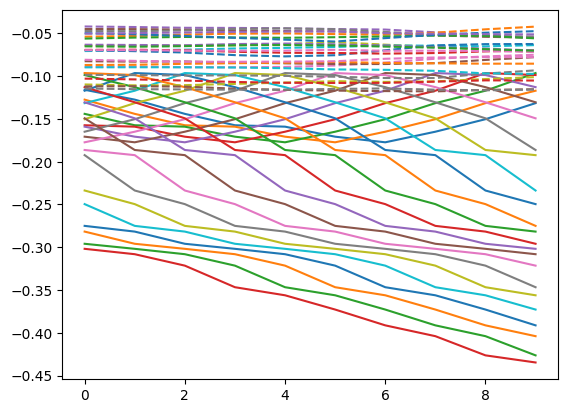

In [ ]:
# Überprüfe, ob das Modell auf der GPU oder der CPU ist
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Das Modell auf das entsprechende Gerät verschieben
model.to(device)

# Die Eingabedaten auch auf das gleiche Gerät verschieben
x_test = x_test.to(device)

# Vorhersagen mit dem Modell
model.eval()
with torch.no_grad():
    y_pred = model(x_test)

# Retransform the scaled data back to original values
y_pred = scaler.inverse_transform(y_pred.cpu().numpy())
y_test = scaler.inverse_transform(y_test.cpu().numpy())

print(x_test.shape)
print(y_pred.shape)
print(y_test.shape)
# Plotten der Ergebnisse
plt.plot(y_test, label="Echter Wasserstand")
plt.plot(y_pred, label="Vorhergesagter Wasserstand", linestyle="dashed")
#plt.legend()
plt.show()


In [ ]:
x_test_cpu = x_test.cpu().numpy()
x_test_cpu

df_compare = pd.DataFrame({"x_test": x_test_cpu.flatten()})


,x_test
0,0.037849
1,0.167063
2,0.394779
3,0.019172
4,0.019172


In [ ]:
df_compare.head()

,x_test
0,0.037849
1,0.167063
2,0.394779
3,0.019172
4,0.019172


In [ ]:
df_model[['time', "values"]].head(5)    



,time,values
0,2025-02-01 00:00:00,"[[[0.5016462207, 3.9498741627, 11.4310970306, ..."
1,2025-02-01 01:00:00,"[[[0.5016462207, 3.9476611614, 11.4490509033, ..."
2,2025-02-01 02:00:00,"[[[0.5016462207, 3.9451875686999998, 11.472709..."
3,2025-02-01 03:00:00,"[[[0.5016462207, 3.9427809715, 11.501332283, 0..."
4,2025-02-01 04:00:00,"[[[0.5016462207, 3.942296505, 11.5287723541, 0..."
